연구자: 정회희 (2018/04/20)

이 실험은 *Understanding Black-box Predictions via Influence Functions*에서 사용한 Hessian vector product를 tensorflow를 사용해서 구현하고, complexity를 확인하기위해 진행된 실험이다.


In [1]:
# The objective of this code is to check whether HVP takes O(p) or O(p^2) compuational complexity
# where x \in R^p

import tensorflow as tf
import time
import matplotlib.pyplot as plt
import numpy as np
from ipdb import set_trace

Implementation Background
-----------------------------
\begin{eqnarray*}
\textbf{g} &=& gradient(y,x)=\left(\frac{\partial y}{\partial x_1},\frac{\partial y}{\partial x_2},\ldots,\frac{\partial y}{\partial x_N}\right)\\
\textbf{h} &=& gradient(\textbf{g},x,grad\_ys=v,stop\_gradient=v)\\
&=&\left(\frac{\partial z}{\partial x_1}\right) 
\text{ where } 
z = \sum_{i=1}^{N}{\frac{\partial y}{\partial x_i}v_i}\\
&=&\left(
\sum_{i=1}^{N}{\frac{\partial^2 y}{\partial x_1 \partial x_i}v_i},
\sum_{i=1}^{N}{\frac{\partial^2 y}{\partial x_2 \partial x_i}v_i}
\ldots, 
\sum_{i=1}^{N}{\frac{\partial^2 y}{\partial x_N \partial x_i}v_i}
\right)\\
&=&\textbf{H}v
\end{eqnarray*}

In [2]:
def hvp(ys, xs, v):
  # hessian vector product using tensorflow
  grads = tf.gradients(ys, xs)
  
  return tf.gradients(grads, xs, grad_ys=v, stop_gradients=v)

In [3]:
iteration = 199
bias = 1

step = 1e7/iteration

operators = []
for i in range(iteration):
  x = tf.constant(1., dtype=tf.float32, shape=(i*step+bias,1))
  y = tf.matmul(x,x,transpose_a=True)
  v = tf.constant(1., dtype=tf.float32, shape=(i*step+bias,1))
  h = hvp(y,x,v)
  operators.append(h)
  # time may increase since the number of operation increases

In [4]:
tf.InteractiveSession()

times = []
for i in range(iteration):
  tic = time.time()
  operators[i][0].eval()
  toc = time.time() - tic
  times.append(toc)

    # first term is delayed by graph construction (may be?)
# therefore, this may be meaningless
times = times[1:] 

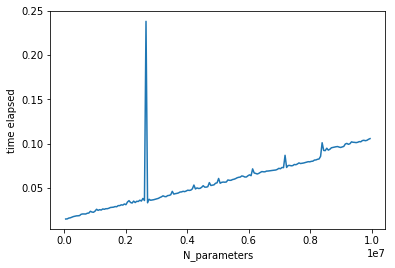

In [5]:
# check times
mean = np.mean(times)
x_axis = np.arange(iteration)*step+bias
x_axis = x_axis[1:]
plt.plot(x_axis,times)
plt.xlabel('N_parameters')
plt.ylabel('time elapsed')
plt.savefig('./images/times_bias_{}_mean_{:5f}.png'.format(bias,mean))
plt.show()

Conclusion
=====

Hessian vector product를 사용하여 hessian matrix와 vector의 곱을 얻을 수 있다.
이는 tensorflow의 tf.gradients를 사용하면 쉽게 얻을 수 있다.

하지만 tensorflow의 tf.gradients의 방식으로 구하는 경우, complexity가 ${O(n)}$라는 보장이 없음.
이를 확인하기 위해서 위 code를 실행함.

Settings
--------
\begin{eqnarray*}
y = f(x)
\text{ where } x \in \mathbb{R}^p, y \in \mathbb{R}
\end{eqnarray*}

Results
--------
밑의 실험 결과 figure를 참고.
x축은 함수의 dimension p 값, y축은 Hessian vector product를 evaluation하는데 드는 값.
x dimension p는 ${1}$에서부터 ${10^7}$까지 변화 시킴.
중간에 한번 튀는 점은 (아마도) x의 dimension이 지나치게 커지면서 이에 따라 graph 크기도 커져 추가적인 메모리 할당을 하면서 발생한 시간이라고 생각함.
참고로 이 튀는 점은 해당 실험을 여러 번 반복하더라도 변함없이 발생함.
그 외 지점에서는 linear하게 증가한다는 것을 확인할 수 있음.
i.e. ${HVP \sim O(p)}$

p가 지나치게 커지게 되면 (아마도) 추가적인 memory를 계속해서 받아야 할거고, 추가적인 memory를 받을 수 없을 경우에는 잘라서 진행할 것. 그 경우 ${O(p)}$가 안 될수도 있음. (e.g. 0.3 근처나 0.82 근처에 step이 생긴 것처럼)
하지만 실제 neural network의 weight는 10M 정도 되기 때문에 이에 compatible한 크기의 neural network라면 p에 linear할 것.